# Fraud Detection in Banking:

This notebook will walk you through my thought process for completing this problem along with answers to the questions:

- Understanding and Cleaning the Data
- Building the Detection Model
- Evaluating Our Model
- Answering important Questions

In [16]:
# setting up imports and enviorment

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')


## data cleaning

In [ ]:
df = pd.read_csv('./Fraud.csv') #adjust this if needed

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Q1) Data cleaning including missing values, outliers and multi-collinearity.

In [ ]:
df.isnull().sum() # should returns 0 for all 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

- luckily our data does not have any null values as 

In [ ]:
# Get a statistical summary of ammount
df[['amount']].describe() 

,amount
count,6.362620e+06
mean,1.798619e+05
std,6.038582e+05
min,0.000000e+00
25%,1.338957e+04
50%,7.487194e+04
75%,2.087215e+05
max,9.244552e+07


- We can see that the max is a 100 times greater than the mean , which indicates something fishy.

- Though this is a outlier , this does not mean that it is a discrepancy, as the biggest transacations may indicate a fraud brewing.

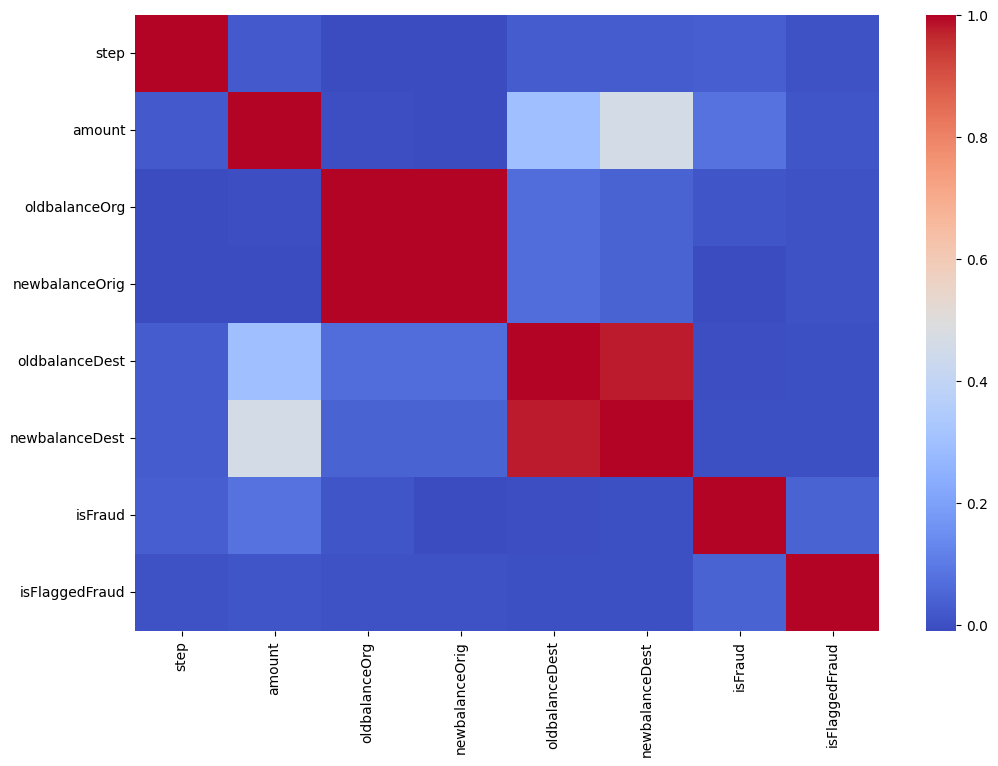

In [ ]:
coMatrix = df.drop(['type','nameOrig','nameDest'], axis=1) # droping non numeric coloums 
coMatrix = coMatrix.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(coMatrix, cmap='coolwarm')
plt.show()

- Excluding correlation to themselves , we can see high correlation between old balance and new balance (oldbalanceOrg and newbalanceOrig), which is logical since change in one is directy related to another.

- Since i am using XGBoost , we dont need to worry about as XGBoost takes care of these issues automatically.(the main reason i choose XGBoost)

## Feature Enggineering & Training

- Row wise Sepration

In [ ]:
df['errBalOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errBalDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'step'], axis=1) # not very useful features 
y = df['isFraud'] # what we need to predict

- Coloumn wise Sepration

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cat_data = ['type'] # categorical data
nums_data = X.select_dtypes(include=np.number).columns.tolist() # numeric useful data

## Preprocessing

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), nums_data), # standard scaling for better results
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_data) # encodes into categories
    ])

# calculating weight for fraud accounts
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        # device='cuda', # Use GPU if available
        tree_method="hist",
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        random_state=41
    ))
])

start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print(f"completed in {end_time - start_time}s")

/home/pik/learnml/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:15:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


completed in 24.373024225234985s


## 2 & 3) Describe your fraud detection model in elaboration. How did you select variables to be included in the model?

A) I have made use of errBalOrig & errBalDest features which are basically (newbalanceOrig - oldbalanceOrg + amount)

- By standerd laws, these new features should be mostly 0 or constant, Otherwise this can indicate something fishy.
- i have used standard scaling for preprocessing as part of common practices.

## 4) Demonstrate the performance of the model by using best set of tools. 

i will consider performance as meaning precision & recall / accuracy

* as the actual performance is very high due to XGBoost

we can observe as follows:

In [21]:
# Get predictions from the model on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(model.score(X_test, y_test))
print(roc_auc_score(y_test, y_pred_proba))
print(average_precision_score(y_test, y_pred_proba))

0.9997178835133954
0.9994697842329467
0.9848098553774889


This is the result we are looking for as my model classifes 99.97% of the cases correctly.

average Precison is 98% which is very good too. 

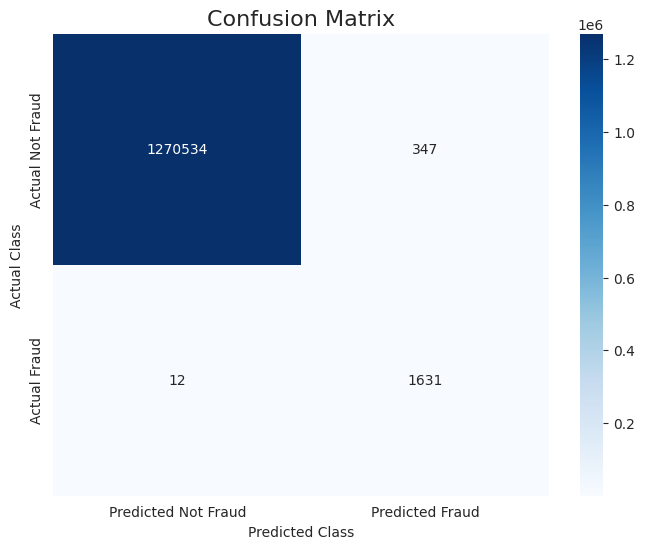

In [25]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Not Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

our model incorrectly classified 12 + 347 cases into the wrong criteria , but this is very low compared to 6362620 transcations and can be easily prevented with an additional manual intervention or another round of classification.

## Q) What are the key factors that predict fraudulent customer? 

The model's most important feature will probably be errbalorig or newbalanceOrig as discussed

we can prove this using:

/tmp/ipykernel_315362/1009173220.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(10), palette='viridis')


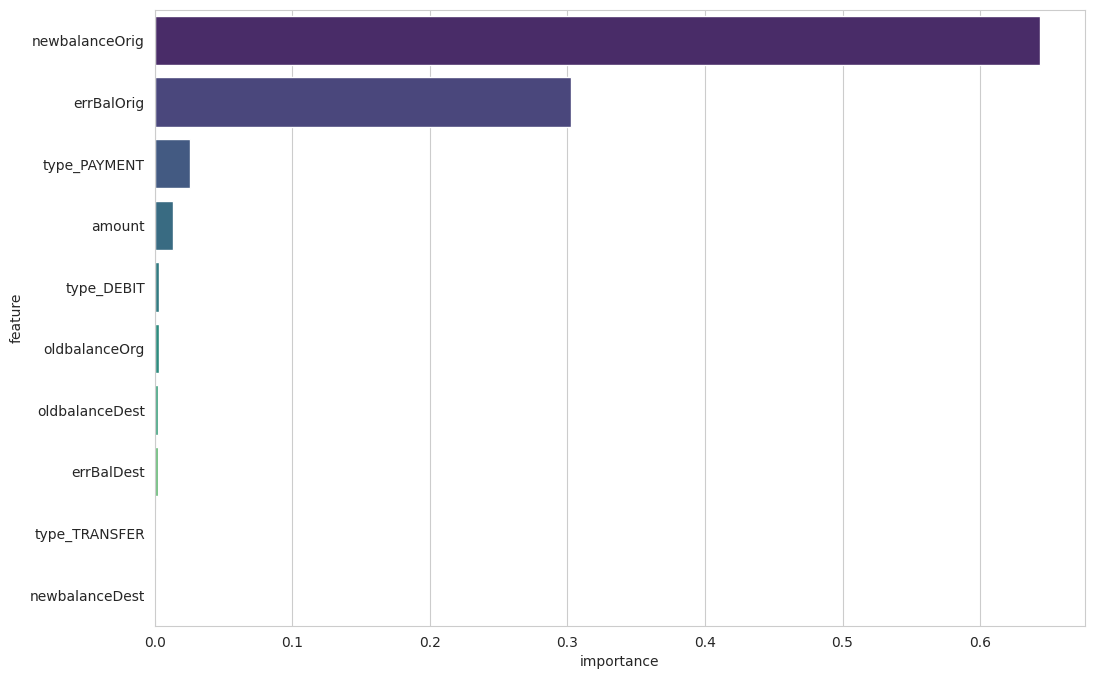

In [28]:

importances = model.named_steps['classifier'].feature_importances_
feature_names = nums_data + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(10), palette='viridis')
plt.show()

## Q6) Do these factors make sense? If yes, How? If not, How not?
A) Yes, these factors make perfect sense and tell a clear story about how fraud is committed in this dataset.

#### How:
The model learned that fraud isn't just about a large amount.

Emptying the Account: The top three factors (errorBalanceOrig, newbalanceOrig, oldbalanceOrg) all relate to the sender's account. The model discovered that the biggest red flag is when a transaction completely drains an account. A fraudulent transaction often sets newbalanceOrig to zero and creates a large errorBalanceOrig because the fraudulent transfer logic is different from normal transactions.

Cashing Out: The model identified CASH_OUT and TRANSFER (further down the list) as important types. 

This perfectly matches the criminal behavior of stealing money: first, they transfer the stolen funds to an account they control, and then they immediately cash it out to get it out of the system.

Our model didn't just learn rules; it learned the behavioral signature of a fraudulent actor.

## Q7) What kind of prevention should be adopted while company update its infrastructure?

A) Based on our model's findings, the company should adopt the following prevention strategies when updating its infrastructure:

- Implement Real-Time Model Scoring: The new infrastructure must be able to run this model on every single transaction before it is processed. Our model is fast enough for this. Each transaction should receive a "fraud score."

- Create Dynamic, Intelligent Rules: The old, static rule of "flag transactions over $200,000" should be replaced with smarter rules based on our model's insights. For example:

- High-Priority Rule: IF transaction_type is 'TRANSFER' AND amount is > 90% of oldbalanceOrg, THEN escalate for immediate review or blocking.

- Error Check Rule: IF errorBalanceOrig is not zero, THEN place a temporary hold on the transaction.

- Introduce "Step-Up" Authentication: For transactions that the model gives a medium-to-high fraud score, the system should automatically trigger an extra security step. This could be sending a one-time password (OTP) to the customer's registered phone. If the real customer enters the code, the transaction proceeds. If not, it's blocked. This prevents false alarms from inconveniencing legitimate customers.

## Q8) Assuming these actions have been implemented, how would you determine if they work?

A) We would determine if the new system works by tracking a few key metrics and running controlled tests.

- Monitor Key Performance Indicators (KPIs): We would compare the "before" and "after" numbers for:

- Fraud Detection Rate (Model Recall): Has the percentage of total fraud we catch gone up?

- Value of Fraud Losses: Has the total dollar amount lost to fraud per month gone down? This is the ultimate measure of success.

- False Positive Rate: Are we flagging fewer legitimate transactions? This measures customer satisfaction.

- For a period of time, we could route 5% of transactions to the old system and 95% to the new one. After a month, we can directly compare the fraud losses and false positive rates between the two groups. This would provide concrete financial evidence of the new model's superiority.

- Continuous Feedback Loop: We must create a system where the findings of the human fraud investigation team are fed back into the dataset. This allows us to constantly re-train our model with new data, ensuring it adapts as fraudsters change their tactics over time.